# HW09

## Exercises to practice unsupervised learning, clustering and PCA

### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework.

In [ ]:
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/data_utils.py
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/image_utils.py
!wget -q https://github.com/DM-GY-9103-2024F-H/HW08/raw/main/HW08_utils.pyc

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

from os import listdir, path
from sklearn.preprocessing import OrdinalEncoder

from data_utils import object_from_json_url
from data_utils import StandardScaler
from data_utils import KMeansClustering, GaussianClustering, SpectralClustering

from data_utils import PCA, RandomForestClassifier, SVC
from data_utils import classification_error, display_confusion_matrix

from image_utils import make_image, open_image

from HW08_utils import CamUtils

### Load Dataset

Let's load up the full [ANSUR](https://www.openlab.psu.edu/ansur2/) dataset that we looked at briefly in [Week 02](https://github.com/DM-GY-9103-2024F-H/WK02) and then again in [HW08](https://github.com/DM-GY-9103-2024F-H/HW08) last week.

This is the dataset that has anthropometric information about U.S. Army personnel.

In [3]:
# Load Dataset
ANSUR_FILE = "https://raw.githubusercontent.com/DM-GY-9103-2024F-H/9103-utils/main/datasets/json/ansur.json"
ansur_data = object_from_json_url(ANSUR_FILE)

# Look at first 2 records
ansur_data[:2]

[{'age': 18,
  'gender': 'F',
  'height': 66,
  'weight': 135,
  'span': 1699,
  'stature': 1645,
  'ear': {'breadth': 30, 'length': 61, 'protrusion': 20},
  'foot': {'breadth': 97, 'length': 243},
  'hand': {'breadth': 78, 'length': 182, 'palm': 108},
  'head': {'height': 243, 'circumference': 557}},
 {'age': 30,
  'gender': 'M',
  'height': 68,
  'weight': 207,
  'span': 1749,
  'stature': 1715,
  'ear': {'breadth': 35, 'length': 63, 'protrusion': 17},
  'foot': {'breadth': 100, 'length': 252},
  'hand': {'breadth': 87, 'length': 184, 'palm': 114},
  'head': {'height': 238, 'circumference': 560}}]

Let's load it into a `DataFrame`, like last week.

In [4]:
# Read into DataFrame
ansur_df = pd.json_normalize(ansur_data)
ansur_df.head()

,age,gender,height,weight,span,stature,ear.breadth,ear.length,ear.protrusion,foot.breadth,foot.length,hand.breadth,hand.length,hand.palm,head.height,head.circumference
0,18,F,66,135,1699,1645,30,61,20,97,243,78,182,108,243,557
1,30,M,68,207,1749,1715,35,63,17,100,252,87,184,114,238,560
2,27,M,67,121,1684,1657,36,59,24,92,251,84,180,103,239,516
3,20,M,73,185,1878,1828,36,60,21,104,280,95,201,124,270,582
4,33,M,76,150,1977,1883,39,65,27,101,271,90,194,113,254,559


### Unsupervised Learning

Let's pretend we are designing next-generation helmets with embedded over-the-ear headphones and we want to have a few options for sizes.

We could use clustering to see if there is a number of clusters that we can divide our population into, so each size covers a similar portion of the population.

We can follow similar steps to regression to create a clustering model that uses features about head and ear sizes:

1. Load dataset (done! 🎉)
2. Encode label features as numbers
3. Normalize the data
4. Separate the feature variables we want to consider (done below)
5. Pick a clustering algorithm
6. Determine number of clusters
7. Cluster data
8. Interpret results

For step $5$, it's fine to just pick an algorithm ahead of time to see what happens, but feel free to experiment and plot results for multiple clustering methods.

In [5]:
## Encode non-numerical features
## i did onehot in last week's homework, so will practice with ordinal even though gender isn't hierarchical
#gender_order = ansur_df["gender"].unique()
gender_order = ["M", "F"]
gender_encoder = OrdinalEncoder(categories = [gender_order])
gender_vals = gender_encoder.fit_transform(ansur_df[["gender"]].values)
ansur_df[["gender"]] = gender_vals
ansur_df





,age,gender,height,weight,span,stature,ear.breadth,ear.length,ear.protrusion,foot.breadth,foot.length,hand.breadth,hand.length,hand.palm,head.height,head.circumference
0,18,1.0,66,135,1699,1645,30,61,20,97,243,78,182,108,243,557
1,30,0.0,68,207,1749,1715,35,63,17,100,252,87,184,114,238,560
2,27,0.0,67,121,1684,1657,36,59,24,92,251,84,180,103,239,516
3,20,0.0,73,185,1878,1828,36,60,21,104,280,95,201,124,270,582
4,33,0.0,76,150,1977,1883,39,65,27,101,271,90,194,113,254,559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5595,43,1.0,62,140,1565,1561,39,69,26,89,246,80,178,98,232,561
5596,24,0.0,70,230,1826,1781,31,62,23,104,287,92,194,122,260,584
5597,27,0.0,68,238,1735,1731,37,58,24,104,268,88,179,112,243,574
5598,23,0.0,71,160,1839,1786,38,63,22,98,269,90,195,115,235,561


In [6]:
## Normalize the data
## had to separate because i was getting an error for some reason... 
# it kept saying 'could not convert string to float: 'M'' even though i had encoded M already and reading ansur_df reflected that
ansur_scaler = StandardScaler()
ansur_scaled_df = ansur_scaler.fit_transform(ansur_df)

In [7]:
## Separate the features we want to consider
ansur_features = ansur_scaled_df[["head.height", "head.circumference", "ear.length", "ear.breadth", "ear.protrusion"]]

In [8]:
## Create Clustering model
n_clusters = 4
km_model = KMeansClustering(n_clusters=n_clusters)
sc_model = SpectralClustering(n_clusters=n_clusters)


## Run the model(s) on the data
km_predicted = km_model.fit_predict(ansur_features)
sc_predicted = sc_model.fit_predict(ansur_features)


## Check errors
print("KMeans distance error:", km_model.distance_error())
print("Spectral distance error:", sc_model.distance_error())



KMeans distance error: 1.5656849339468795
Spectral distance error: 1.5777306097781907


In [9]:
print(ansur_features.min())
print(ansur_features.max())

head.height          -3.641540
head.circumference   -3.710931
ear.length           -3.447040
ear.breadth          -3.150521
ear.protrusion       -2.929279
dtype: float64
head.height           3.865765
head.circumference    3.540511
ear.length            3.804589
ear.breadth           3.381358
ear.protrusion        3.708930
dtype: float64


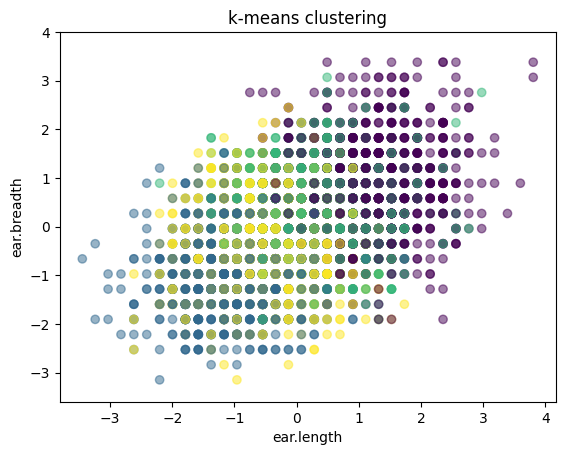

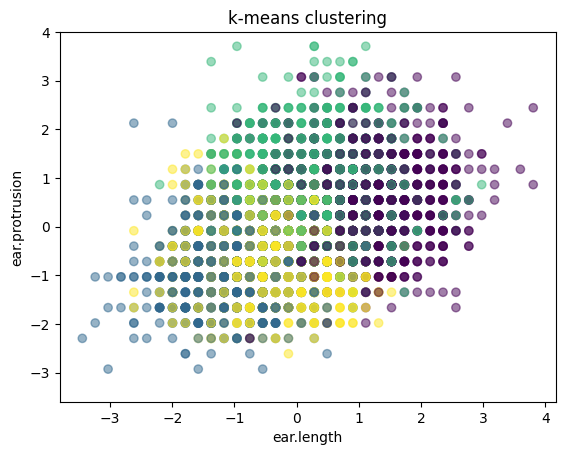

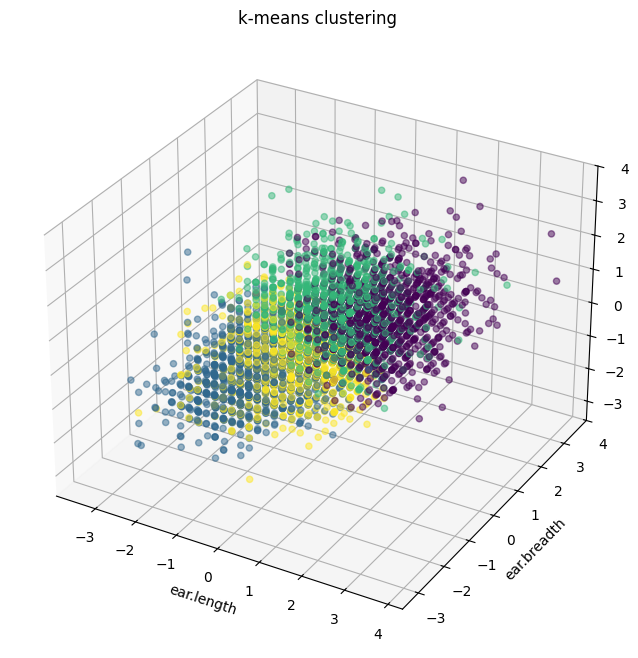

In [12]:
## Plot clusters as function of 2 or 3 variables
# kmeans

clusters = km_predicted["clusters"]

xl, yl, zl = "ear.length", "ear.breadth", "ear.protrusion"
x = ansur_scaled_df[xl]
y = ansur_scaled_df[yl]
z = ansur_scaled_df[zl]

# 2D
plt.scatter(x, y, c=clusters, marker='o', linestyle='', alpha=0.5)
plt.title("k-means clustering")
plt.xlabel(xl)
plt.ylabel(yl)
plt.ylim([-3.6, 4])
plt.show()

plt.scatter(x, z, c=clusters, marker='o', linestyle='', alpha=0.5)
plt.title("k-means clustering")
plt.xlabel(xl)
plt.ylabel(zl)
plt.ylim([-3.6, 4])
plt.show()

# 3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(x, y, z, c=clusters, marker='o', linestyle='', alpha=0.5)

ax.set_title("k-means clustering")
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_zlabel(zl)

ax.set_ylim(-3.6, 4)
ax.set_zlim(-3.6, 4)

plt.show()


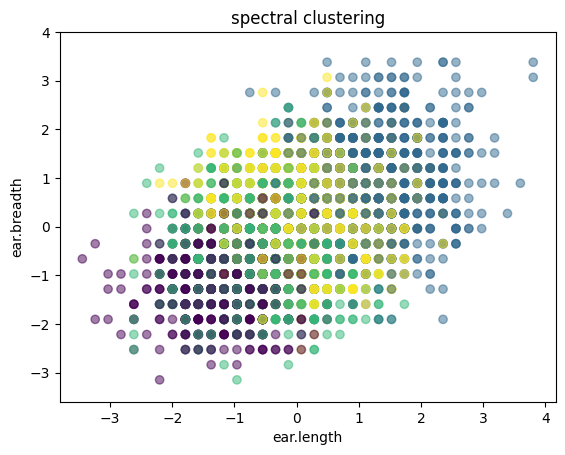

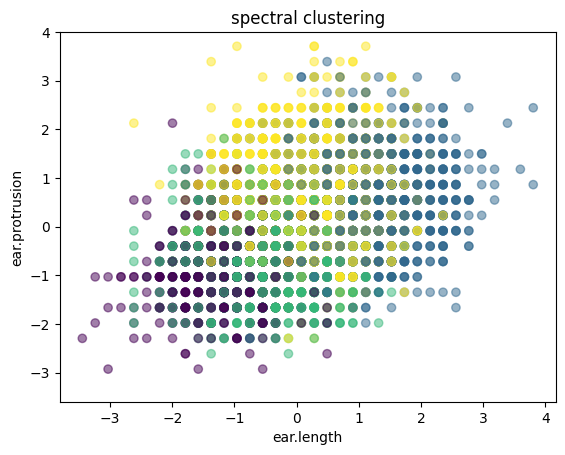

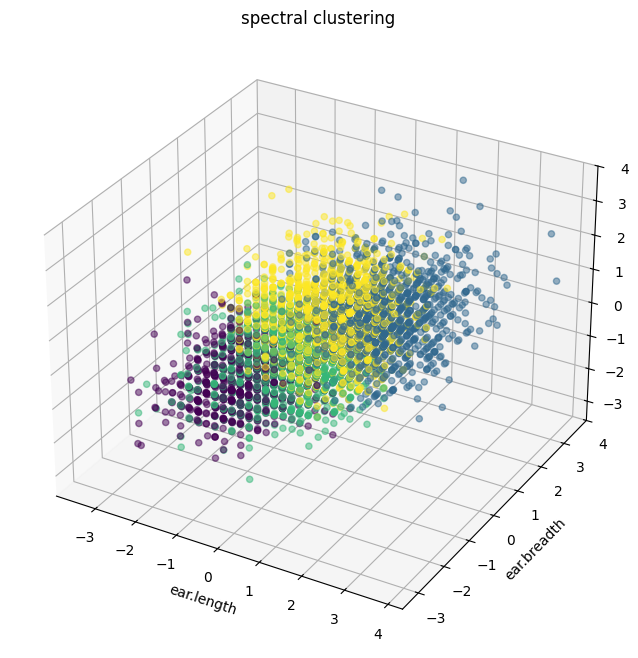

In [13]:
## Plot clusters as function of 2 or 3 variables
# spectral

clusters = sc_predicted["clusters"]

xl, yl, zl = "ear.length", "ear.breadth", "ear.protrusion"
x = ansur_scaled_df[xl]
y = ansur_scaled_df[yl]
z = ansur_scaled_df[zl]

# 2D
plt.scatter(x, y, c=clusters, marker='o', linestyle='', alpha=0.5)
plt.title("spectral clustering")
plt.xlabel(xl)
plt.ylabel(yl)
plt.ylim([-3.6, 4])
plt.show()

plt.scatter(x, z, c=clusters, marker='o', linestyle='', alpha=0.5)
plt.title("spectral clustering")
plt.xlabel(xl)
plt.ylabel(zl)
plt.ylim([-3.6, 4])
plt.show()

# 3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(x, y, z, c=clusters, marker='o', linestyle='', alpha=0.5)

ax.set_title("spectral clustering")
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_zlabel(zl)

ax.set_ylim(-3.6, 4)
ax.set_zlim(-3.6, 4)

plt.show()


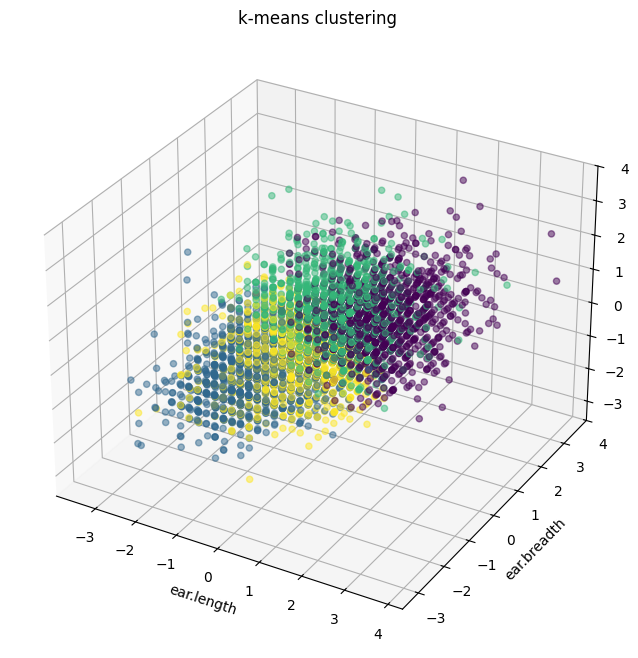

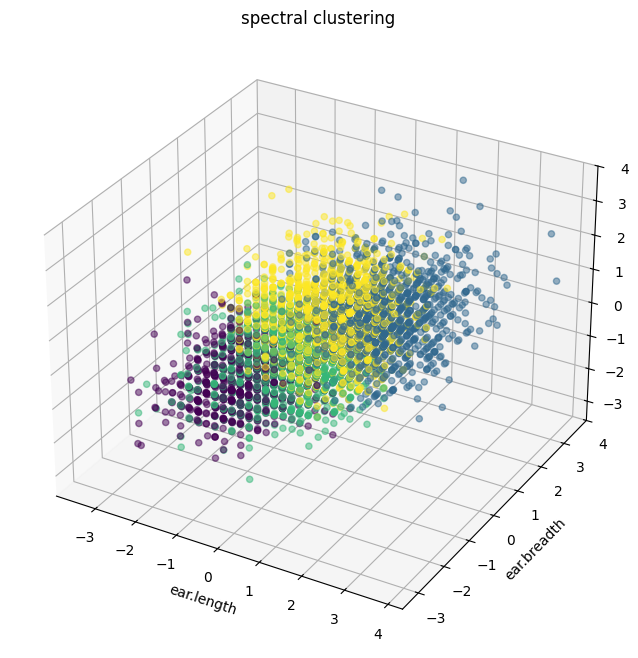

In [14]:
# compare kmeans and spectral 3d side by side
xl, yl, zl = "ear.length", "ear.breadth", "ear.protrusion"
x = ansur_scaled_df[xl]
y = ansur_scaled_df[yl]
z = ansur_scaled_df[zl]

#kmeans
km_clusters = km_predicted["clusters"]
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(x, y, z, c=km_clusters, marker='o', linestyle='', alpha=0.5)

ax.set_title("k-means clustering")
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_zlabel(zl)

ax.set_ylim(-3.6, 4)
ax.set_zlim(-3.6, 4)

plt.show()

# spectral

sc_clusters = sc_predicted["clusters"]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(x, y, z, c=sc_clusters, marker='o', linestyle='', alpha=0.5)

ax.set_title("spectral clustering")
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_zlabel(zl)

ax.set_ylim(-3.6, 4)
ax.set_zlim(-3.6, 4)

plt.show()


### Interpretation

<span style="color:hotpink;">
Which clustering algorithm did you choose?<br>
Did you try a different one?<br>
Do the clusters make sense ? Do they look balanced ?
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>

I tried kmeans and spectral. I feel like they look very similar and there is a lot of overlap, which perhaps makes sense as I chose all the ear features. Perhaps having less clusters will be better. 

## Figure out how many cluster

Experiment with the number of clusters to see if the initial choice makes sense.

The [WK09](https://github.com/DM-GY-9103-2024F-H/WK09) notebook had a for loop that can be used to plot errors versus number of clusters.

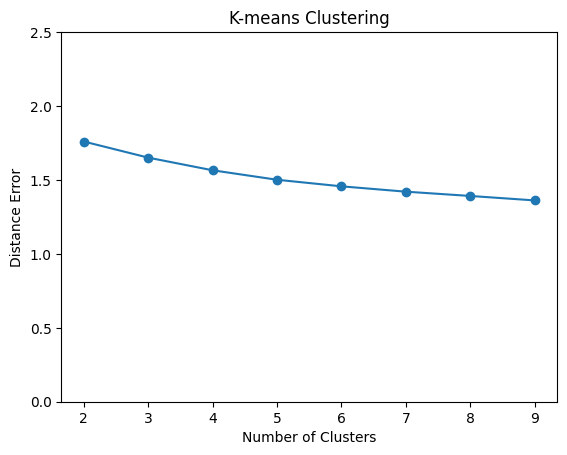

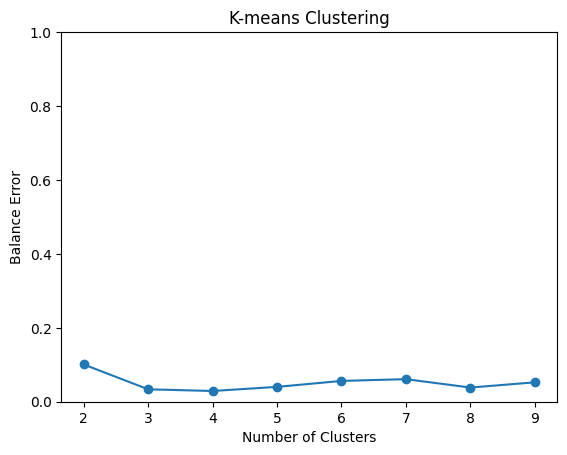

In [16]:
## Plot errors and pick how many cluster

# try 2 - 10 clusters for K-Means Clustering
num_clusters = list(range(2,10))

# collect distance, likelihood and balance errors
dist_err = []
like_err = []
bala_err = []

# get distance, likelihood and balance for different clustering sizes
for n in num_clusters:
  mm = KMeansClustering(n_clusters=n)
  mm.fit_predict(ansur_features)
  dist_err.append(mm.distance_error())
  bala_err.append(mm.balance_error())

# plot errors as function of number of clusters
plt.plot(num_clusters, dist_err, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Distance Error")
plt.title("K-means Clustering")
plt.ylim([0, 2.5])
plt.show()

plt.plot(num_clusters, bala_err, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Balance Error")
plt.title("K-means Clustering")
plt.ylim([0, 1])
plt.show()


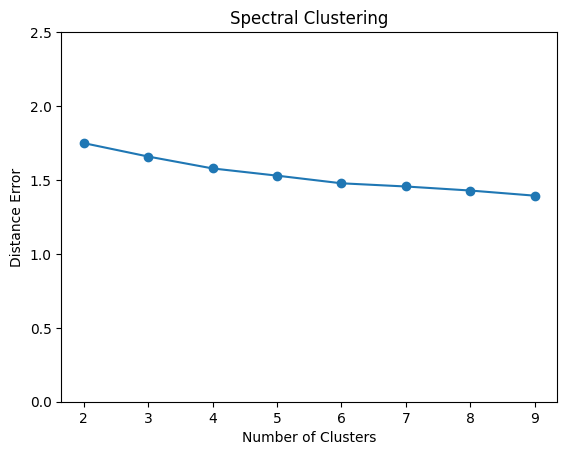

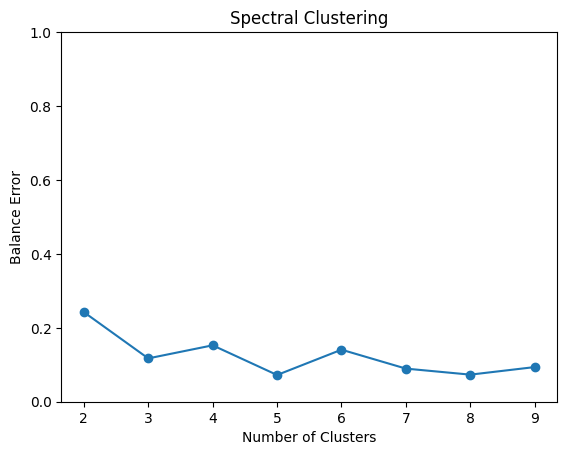

In [17]:
num_clusters = list(range(2,10))

# collect distance, likelihood and balance errors
dist_err = []
like_err = []
bala_err = []

# get distance, likelihood and balance for different clustering sizes
for n in num_clusters:
  mm = SpectralClustering(n_clusters=n)
  mm.fit_predict(ansur_features)
  dist_err.append(mm.distance_error())
  bala_err.append(mm.balance_error())

# plot errors as function of number of clusters
plt.plot(num_clusters, dist_err, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Distance Error")
plt.title("Spectral Clustering")
plt.ylim([0, 2.5])
plt.show()

plt.plot(num_clusters, bala_err, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Balance Error")
plt.title("Spectral Clustering")
plt.ylim([0, 1])
plt.show()

### Interpretation

<span style="color:hotpink;">
Based on the graphs of errors versus number of clusters, does it look like we should change the initial number of clusters ?<br>
How many clusters should we use ? Why ?
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>

For kmeans, a low distance and balance error is at 8 clusters. For spectral, the lowest possible balance error is 5 clusters. I think there is an argument either way for changing the clusters. On one hand, it is good to make error as small as possible. On the other hand, the difference in error, especially for kmeans, is really small that it might not make a huge difference. 

### Revise Number of Clusters.

Re-run with the new number of clusters and plot the data in $2D$ or $3D$.

This can be the same graph as above.

KMeans distance error: 1.5010131842595775
Spectral distance error: 1.5291671349428673


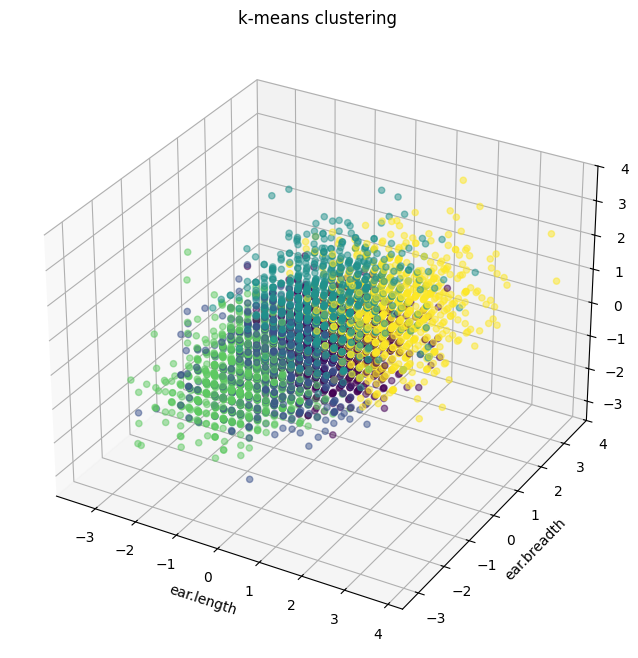

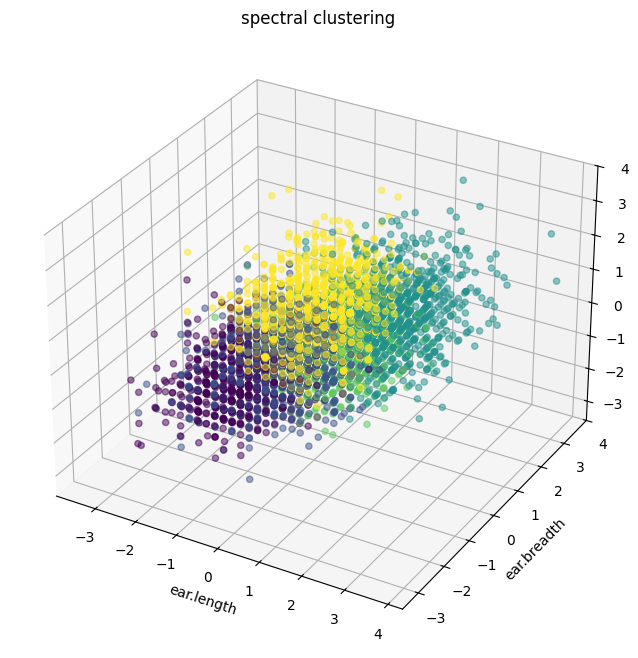

In [18]:
## Re-run clustering with final number of clusters
n_clusters = 5
km_model = KMeansClustering(n_clusters=n_clusters)
sc_model = SpectralClustering(n_clusters=n_clusters)

## Run the model on the training data
km_predicted = km_model.fit_predict(ansur_features)
sc_predicted = sc_model.fit_predict(ansur_features)

## Check errors
print("KMeans distance error:", km_model.distance_error())
print("Spectral distance error:", sc_model.distance_error())

## Plot in 3D
xl, yl, zl = "ear.length", "ear.breadth", "ear.protrusion"
x = ansur_scaled_df[xl]
y = ansur_scaled_df[yl]
z = ansur_scaled_df[zl]

#kmeans
km_clusters = km_predicted["clusters"]
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(x, y, z, c=km_clusters, marker='o', linestyle='', alpha=0.5)

ax.set_title("k-means clustering")
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_zlabel(zl)

ax.set_ylim(-3.6, 4)
ax.set_zlim(-3.6, 4)

plt.show()

# spectral

sc_clusters = sc_predicted["clusters"]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(x, y, z, c=sc_clusters, marker='o', linestyle='', alpha=0.5)

ax.set_title("spectral clustering")
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_zlabel(zl)

ax.set_ylim(-3.6, 4)
ax.set_zlim(-3.6, 4)

plt.show()

### Interpretation

<span style="color:hotpink;">
Do these look better than the original number of clusters?
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>

I think that the clusters do look more distinct. 

## PCA and Classification

Let's practice doing some more image classification with `PCA` and analyzing the results.

The dataset is the same as last week. It has images from $25$ different security cameras, and our task is to separate them by camera. Some of the cameras move, some of them don't, and there are more than $1000$ images, so there's no way we want to do this by hand.

Let's start by loading the training images into a list of pixels, like we did with the `faces` dataset in class.

### Loading Data

If we look at the images in `./data/images/0801-500/train/`, we'll notice that they are named and organized in a slightly different way. They're all in the same directory and the first part of their filename specifies which camera they came from. Even though those `ids` are numbers, they're not sequential, so we'll use some helper functions to extract a unique `label` from their filenames.

This is exactly what the `OrdinalEncoder` class does, but since we only have to encode this one column, we'll do it by hand while we read the files in.

In [19]:
# this creates a list of all the files in a given directory, that end in .jpg
train_files = [f for f in listdir("./data/images/0801-500/train") if f.endswith(".jpg")]

In [20]:
# TODO: check and see what is inside the list here
train_files[:5]

['28-64.jpg', '31-05.jpg', '08-53.jpg', '01-30.jpg', '19-48.jpg']

Now we'll read the image pixels and extract their labels. `CamUtils.get_label()` is the helper function we'll use to "encode" and return a label id based on the filename.

In [21]:
pixel_data = []
label_data = []

for fname in train_files:
  label = CamUtils.get_label(fname)
  img = open_image(path.join("./data/images/0801-500/train", fname))
  pixel_data.append(img.pixels)
  label_data.append(label)

In [22]:
# TODO: check if labels got extracted correctly by looking at 
#       the first few items of the label list and the filename list

print(label_data[:5])
print(train_files[:5])

[23, 24, 6, 0, 15]
['28-64.jpg', '31-05.jpg', '08-53.jpg', '01-30.jpg', '19-48.jpg']


Like last week, the labels and the filenames won't match exactly since labels start at $0$ and the filenames start at $01$ and skip some numbers.

We can open some images from pixels, just to make sure we loaded them correctly:

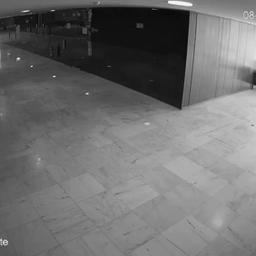

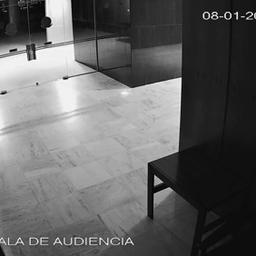

In [23]:
display(make_image(pixel_data[0], width=256))
display(make_image(pixel_data[10], width=256))

### PCA

Create a `DataFrame` called `cam_pca_df` by running `PCA` on the list of pixel data, just like we did in class, and then append a `label` column to it, just like we did last week with: `train_df["label"] = label_data`.

You can change how many components to extract from the images later, but for this first run just use $10$ components so we can compare classification with $10$ `PCA` components to the classification with $10$ random features from `HW08`.  Make sure to confirm how much of the `variance` is preserved by this transformation.

In [64]:
# TODO: run PCA, get DataFrame
train_df = pd.DataFrame(pixel_data)

cam_pca = PCA(n_components=10)
cam_pca_df = cam_pca.fit_transform(pixel_data)

    
# TODO: add "label" column
cam_pca_df["label"] = label_data



# TODO: print variance
print("n: 10, variance:", cam_pca.explained_variance())

# TODO: take a look at the first 5 rows
display(cam_pca_df.head()[:5])


n: 10, variance: 0.7852542234846752


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,label
0,3806.710420,-2697.584968,5286.902808,-732.751030,-4771.197686,1967.880126,-1745.537497,-2300.431961,1927.009828,-845.474763,23
1,-10587.368383,8798.956092,-1936.086107,1612.280463,1735.170916,-1103.647923,-508.965013,2074.628346,1930.145727,-1937.239117,24
2,68.211536,5796.212705,2431.049395,1465.251248,-1569.237530,349.097992,2258.260206,3556.662145,-1243.955403,941.342108,6
3,-10283.276623,-7454.969441,1465.377864,-2144.856985,-776.993364,-1890.129652,2315.672428,-1577.313194,-559.247496,-440.594200,0
4,10706.388370,3114.193836,-2462.939756,-2917.744186,5451.233442,-3756.882487,1893.658784,265.644461,2476.750996,467.877960,15


In [47]:
# testing number of components
# TODO: run PCA, get DataFrame
train_df = pd.DataFrame(pixel_data)

cam_pca = PCA(n_components=22)
cam_pca_df = cam_pca.fit_transform(pixel_data)

    
# TODO: add "label" column
cam_pca_df["label"] = label_data



# TODO: print variance
print("n: 22, variance:", cam_pca.explained_variance())

# TODO: take a look at the first 5 rows
display(cam_pca_df.head()[:5])


n: 22, variance: 0.9022477004369505


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,label
0,3806.710420,-2697.584968,5286.902807,-732.751042,-4771.198631,1967.889184,-1745.572832,-2300.480665,1927.860338,-843.835179,...,143.079863,-436.763334,-807.586802,291.222640,-1323.540649,1103.005417,55.440713,-14.757960,1657.350618,23
1,-10587.368383,8798.956092,-1936.086107,1612.280460,1735.170793,-1103.646960,-508.971495,2074.618927,1930.273044,-1936.826108,...,-1757.279940,44.945622,-2141.669158,-443.638976,25.242221,-496.496883,-298.238008,533.575498,-150.561696,24
2,68.211536,5796.212706,2431.049395,1465.251246,-1569.238414,349.106787,2258.233090,3556.619050,-1243.067440,942.881059,...,-95.699967,-227.806351,-664.704957,-1360.452858,-2977.276411,-1417.607069,932.763980,2028.120755,24.031181,6
3,-10283.276623,-7454.969441,1465.377864,-2144.856968,-776.992417,-1890.137761,2315.708684,-1577.260241,-559.964083,-442.274181,...,-615.785652,314.312212,566.355341,986.000949,1471.197575,-934.055481,-293.004891,-11.721577,68.775083,0
4,10706.388370,3114.193836,-2462.939756,-2917.744204,5451.233249,-3756.880927,1893.640507,265.629639,2476.821253,468.478460,...,740.026875,2189.037327,220.348724,544.995340,-894.801234,-2050.060412,-1773.081361,-625.777002,-460.305026,15


### Interpretation

<span style="color:hotpink">
How many components did you keep ?<br>
Did you try different numbers ?<br>
What percent of variance is kept by this transformation?
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>

I kept 22 because I thought 90% was pretty good. I tried 20, 25, and 30 as well. 

### Reconstruct

Before we go run our classification, let's take a look at some reconstructed images, just to make sure they make sense.

Take a look at reconstructed versions of images $0$, $10$, and whichever other images you might have opened above.

We did this in class. It involves a `inverse_transform()` function.




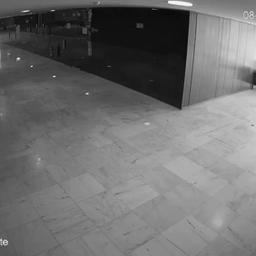

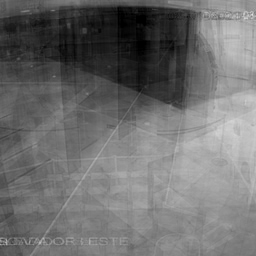

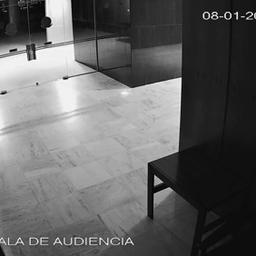

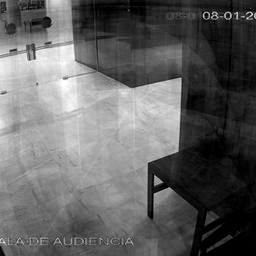

In [52]:
# TODO: reconstruct image at index 0
pca_pixels = cam_pca.inverse_transform(cam_pca_df)

display(make_image(pixel_data[0], width=256))
display(make_image(pca_pixels.loc[0], width=256))

# TODO: reconstruct image at index 10

display(make_image(pixel_data[10], width=256))
display(make_image(pca_pixels.loc[10], width=256))

The reconstructed images should look blurrier and noisier than the original ones, but they should still look something like the original ones.

### Classify !

Train a `RandomForestClassifier` on the `PCA` data.

Remember to separate the output feature (`label`) from the input features (`PC0`, `PC1`, etc).

In [54]:
# TODO: create a classifier
train_model = RandomForestClassifier()

# TODO: split input and output features
NUM_FEATURES = 10
chosen_columns = cam_pca_df.columns[:NUM_FEATURES]
train_features = cam_pca_df.drop(columns="label")
train_features = cam_pca_df[chosen_columns]

out_features = cam_pca_df["label"]


# TODO: fit the model
train_model.fit(train_features, out_features)

# TODO: run predictions
train_predictions = train_model.predict(train_features)


### Measure Error

For the train set we could use the generic `classification_error()` function that we've used before because we have the true labels for each file, but for measuring accuracy for our `test` set classification, which has secret labels, we have to use a more specific function from the `CamUtils` class.

The function is called `classification_accuracy()` and it takes $2$ parameters, a list of filenames and the predicted labels associated with those filenames.

The result is an accuracy score ratio, between $0.0$ and $1.0$.

We can run this function on the `train` set as well:

In [55]:
# train_files is the list of files we got way up above
CamUtils.classification_accuracy(train_files, train_predictions)

1.0

### Interpretation

<span style="color:hotpink">
What does this mean?<br>
Should we expect the same result from the test dataset?<br>
Why, or why not?
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>

The classification accuracy score is a 1 which means the test should run properly, but it won't be the same result. It is a 1 since we trained the model on the actual data, introducing new data in the test that hasn't had anything to do with training the model should lower the accuracy. 

### Run on Test set

Now we'll open the image files inside the `./data/images/0801-500/test/` directory, using almost the exact same steps as we did above to create a `DataFrame` with the exception that we don't have labels for these images.

In [58]:
# TODO: create a list of files in the test/ directory
test_files = [f for f in listdir("./data/images/0801-500/test/") if f.endswith(".jpg")]

# TODO: check its length and content
print(len(test_files))
test_files[:5]

1573


['15709132.jpg',
 '12405239.jpg',
 '10894318.jpg',
 '15584424.jpg',
 '10656623.jpg']

We'll use a similar loop to extract the pixel information from these images, except we don't have `label` data, just pixels.

In [59]:
test_pixel_data = []

for fname in test_files:
  img = open_image(path.join("./data/images/0801-500/test", fname))
  test_pixel_data.append(img.pixels)

Now we can run `PCA` and the `RandomForestClassifier`.

Since those are already trained, all we have to do is run their `transform()` function on the data.

In [60]:
# TODO: run PCA on test pixels, get DataFrame
#       this is the same PCA that was created above, not a new one

test_pca_df = cam_pca.fit_transform(test_pixel_data)

# TODO: take a look at the first 5 rows
display(test_pca_df.head()[:5])

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21
0,10712.320176,-2543.556192,2673.576510,1190.657955,1763.857664,338.537552,-2504.771843,-1259.793536,768.416643,309.770438,...,-1510.591159,407.811689,-244.426237,1056.930423,1145.081367,-680.378634,921.311317,2176.937481,414.756973,-144.071236
1,11119.967413,-9852.345814,-4766.214244,-1695.955501,444.274598,-900.580660,851.897299,-2083.959340,167.959196,-2631.860118,...,980.665521,286.966163,495.461401,-1196.895558,-875.648722,800.040913,-1040.567946,268.796346,196.003894,117.568527
2,6015.103081,-8487.937846,4314.995030,-3878.830851,-1791.109402,2922.928659,-5141.450593,1395.088628,2109.052339,4770.830133,...,1134.996438,-750.769511,1324.059621,-1281.740236,1923.919055,-24.978320,822.772578,-287.880770,1011.368414,-316.838273
3,6923.389418,1628.383514,-13099.494912,-3919.764213,-3177.206114,3085.628530,2330.810804,-1917.090767,459.225440,1705.649320,...,-140.039503,3623.274448,407.373545,-234.653194,810.805604,1718.828361,-682.105307,-447.654984,751.418223,128.000277
4,-12023.423742,-13008.458714,-2744.120813,2751.401218,2558.086314,-3506.604608,1387.630200,304.518032,-3158.369415,-1177.393192,...,-474.635562,44.077612,-612.838230,2043.199256,2795.335115,-101.784323,-1640.897491,-1609.540441,-2180.186799,1384.533577


It's always a good idea to check the result of the `PCA` transformation by looking at the `DataFrame` and reconstructing some images.

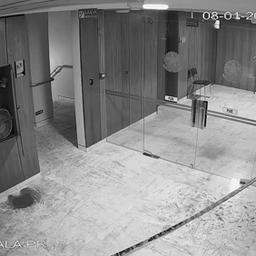

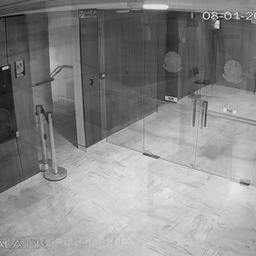

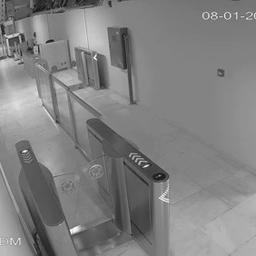

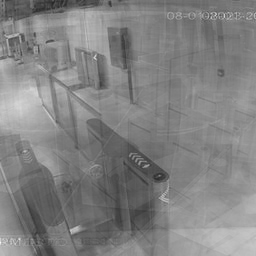

In [62]:
test_pca_pixels = cam_pca.inverse_transform(test_pca_df)

# TODO: reconstruct one or two images
display(make_image(test_pixel_data[0], width=256))
display(make_image(test_pca_pixels.loc[0], width=256))

display(make_image(test_pixel_data[110], width=256))
display(make_image(test_pca_pixels.loc[110], width=256))

# TODO: take a look at the first 5 rows

### Interpretation

<span style="color:hotpink"><br>
The reconstructed images from the `test` set will always be noisier than the `train` images.<br><br>
Why?<br><br>
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>

Because this dataset had nothing to do with the training, it will end up that it won't be as accurate and thus noisier. Funnily enough, the first image looks to be the least noisy of all the photos. 



Run the classifier and get predicted labels. Then get its accuracy ratio is by running the `CamUtils.classification_accuracy()` function with the list of filenames and list of predictions.

In [65]:
test_pca_df.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21
0,10712.320176,-2543.556192,2673.576510,1190.657955,1763.857664,338.537552,-2504.771843,-1259.793536,768.416643,309.770438,...,-1510.591159,407.811689,-244.426237,1056.930423,1145.081367,-680.378634,921.311317,2176.937481,414.756973,-144.071236
1,11119.967413,-9852.345814,-4766.214244,-1695.955501,444.274598,-900.580660,851.897299,-2083.959340,167.959196,-2631.860118,...,980.665521,286.966163,495.461401,-1196.895558,-875.648722,800.040913,-1040.567946,268.796346,196.003894,117.568527
2,6015.103081,-8487.937846,4314.995030,-3878.830851,-1791.109402,2922.928659,-5141.450593,1395.088628,2109.052339,4770.830133,...,1134.996438,-750.769511,1324.059621,-1281.740236,1923.919055,-24.978320,822.772578,-287.880770,1011.368414,-316.838273
3,6923.389418,1628.383514,-13099.494912,-3919.764213,-3177.206114,3085.628530,2330.810804,-1917.090767,459.225440,1705.649320,...,-140.039503,3623.274448,407.373545,-234.653194,810.805604,1718.828361,-682.105307,-447.654984,751.418223,128.000277
4,-12023.423742,-13008.458714,-2744.120813,2751.401218,2558.086314,-3506.604608,1387.630200,304.518032,-3158.369415,-1177.393192,...,-474.635562,44.077612,-612.838230,2043.199256,2795.335115,-101.784323,-1640.897491,-1609.540441,-2180.186799,1384.533577


In [72]:
# TODO: run classifier. This is the same classifier already fitted on the train data above
NUM_FEATURES = 10
chosen_columns = test_pca_df.columns[:NUM_FEATURES]

test_features = test_pca_df[chosen_columns]

test_predictions = train_model.predict(test_features)

# TODO: get accuracy
CamUtils.classification_accuracy(test_files, test_predictions)

0.38080101716465353

### Interpretation

<span style="color:hotpink">
What's the accuracy ? How could we improve that if we wanted ?<br>
How does this compare to last week's classification model? They can both be tuned to perform well, but how many features did we need last week to get an accuracy comparable to this?
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>

The accuracy is only 38%. Like last week, we should increase the number of features to increase the accuracy. It seems to be doing worse compared to last week's classification model. Which had 65% accuracy with 10 features. 